In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import chainer
from chainer import serializers
from PIL import Image
import chainer.functions as F

import sys
sys.path.insert(0, '../models')
sys.path.insert(0, '../')

import drn
import drn_pytorch
import torch
from torch.autograd import Variable
import importlib
importlib.reload(drn)
importlib.reload(drn_pytorch)

import cupy as cp
from chainer import cuda
from skimage.segmentation import felzenszwalb
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.segmentation import find_boundaries
from sklearn import cluster
from sklearn import feature_extraction
from skimage.future import graph

import kmeans
import copy

chainer.config.train = False

/home/shunta/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/cupy-3.0.0a1-py3.6-linux-x86_64.egg/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


In [2]:
val_img_files = {os.path.basename(fn): fn
                 for fn in glob.glob(
                     '/mnt/vol04/datasets/cityscapes/leftImg8bit/val/*/*.png')}
val_npz_files = {os.path.splitext(os.path.basename(fn))[0]: fn
                 for fn in glob.glob('../data/val_road_void_gt/*.npz')}
val_imgs_labels = [(val_img_files[key], val_npz_files[key]) for key in val_npz_files.keys()]

In [3]:
model = drn.drn_c_26(out_map=True, out_middle=True)
serializers.load_npz('../models/drn_c_26.npz', model)
model.to_gpu(0)

# model = drn_pytorch.drn_c_26(pretrained=True, out_map=True, out_middle=True)
# model.cuda()

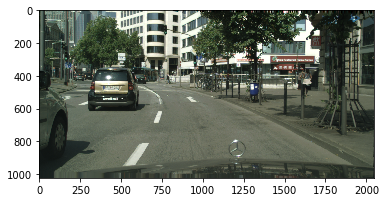

n_maps: 8
pred: (1, 1000, 128, 256)
(1, 1024, 128, 256)


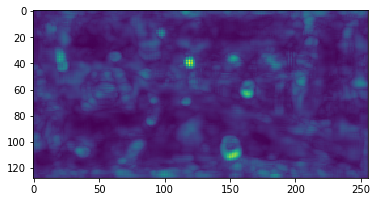

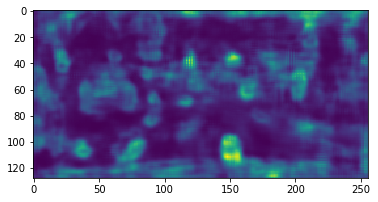

In [4]:
img_fn, label_fn = val_imgs_labels[0]
img = np.asarray(Image.open(img_fn), dtype=np.float32)

plt.imshow(img / 255.)
plt.show()

img = img.transpose(2, 0, 1)

pred, maps = model.predict(model.xp.asarray(img))
maps = [cuda.to_cpu(m.array) for m in maps]
print('n_maps:', len(maps))
print('pred:', pred.shape)

# img = torch.from_numpy(img[None, ...])
# img = img.cuda()
# out, maps = model(Variable(img))
# out = out.data.cpu().numpy()
# maps = [m.data.cpu().numpy() for m in maps]
# print(out.shape)
# for i, m in enumerate(maps):
#     print(i, m.shape)

# Concat layer6 and 7
feature_map = np.concatenate([maps[6], maps[7]], axis=1)
print(feature_map.shape)

plt.imshow(feature_map[0].max(axis=0))
plt.show()

plt.imshow(feature_map[0].mean(axis=0))
plt.show()

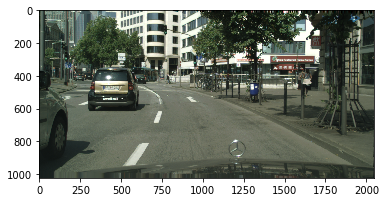

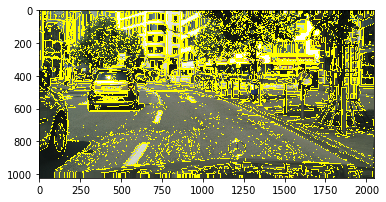

(6417, 1024)


In [5]:
img = np.asarray(Image.open(img_fn), dtype=np.float32)
img = img / 255.
h, w, c = img.shape

plt.imshow(img)
plt.show()

superpixels = felzenszwalb(img, scale=100.0)
# superpixels = slic(img)

plt.imshow(mark_boundaries(img, superpixels))
plt.show()

resized_features = F.resize_images(feature_map, (h, w)).array
resized_features = cuda.to_cpu(resized_features)[0].transpose(1, 2, 0)

superpixel_features = []
for idx in np.sort(np.unique(superpixels)):
    superpixel_feature = np.mean(resized_features[superpixels == idx], axis=0)
    # superpixel_feature = np.max(resized_features[superpixels == idx], axis=0)
    superpixel_features.append(superpixel_feature)
superpixel_features = np.asarray(superpixel_features)

print(superpixel_features.shape)

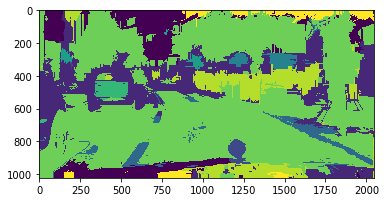

In [7]:
centers, pred = kmeans.fit(cuda.to_gpu(superpixel_features, 0), 10, 1000, True)
centers, pred = cuda.to_cpu(centers), cuda.to_cpu(pred)

clustering_result = np.zeros_like(superpixels)
for superpixel_idx, cluster_id in enumerate(pred):
    clustering_result[superpixels == superpixel_idx] = cluster_id
plt.imshow(clustering_result)
plt.show()

weights: (1024, 2048)
superpixels: (1024, 2048)


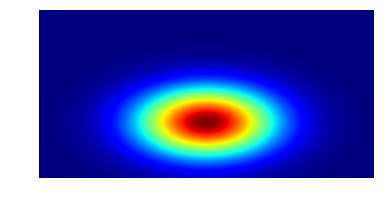

(6417,)
0.998579247197 0.0707770234986
diff < eps
c0: 438
c1: 1800
c2: 187
c3: 354
c4: 3638


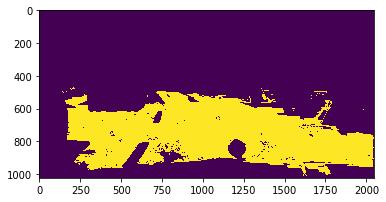

In [53]:
h, w = superpixels.shape
xcoord, ycoord = np.meshgrid(np.arange(w), np.arange(h))

ymean, xmean = h - h // 3, w // 2  # Center just above Mercedes logo
y_sigma = h / 10
x_sigma = w / 10
weights = np.exp(-((ycoord - ymean)**2 / (2 * y_sigma)**2 + (xcoord - xmean)**2 / (2 * x_sigma)**2))
print('weights:', weights.shape)
print('superpixels:', superpixels.shape)

plt.imshow(weights, cmap="jet")
plt.axis('off')
plt.show()

superpixel_weights = np.array([])
for idx in np.sort(np.unique(superpixels)):
    mean_weights = weights[superpixels == idx].mean()
    superpixel_weights = np.append(superpixel_weights, mean_weights)
print(superpixel_weights.shape)

result = kmeans.kmeans_weighted(
    k=5,
    X=superpixel_features,
    random_state=0,
    weights=superpixel_weights)

clustering_result = np.zeros_like(superpixels)
for superpixel_idx, cluster_id in enumerate(result.labels_):
    if cluster_id == 0:
        clustering_result[superpixels == superpixel_idx] = 1
plt.imshow(clustering_result)
plt.show()

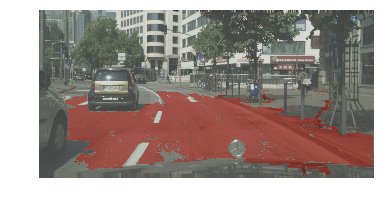

In [71]:
plt.imshow(img)
plt.imshow(clustering_result, alpha=0.4, cmap=plt.cm.Set1_r)
plt.axis('off')
plt.show()
plt.savefig()

In [15]:
chainer.config.train = True
road_model = drn.make_drn(out_map=True, out_middle=True, num_classes=2)
serializers.load_npz(
    '../results/DilatedResNet_2017-11-07_02-16-43_0/snapshot_iter_10000', road_model,
    path='updater/model:main/predictor/')
road_model.to_gpu(0)
chainer.config.train = False

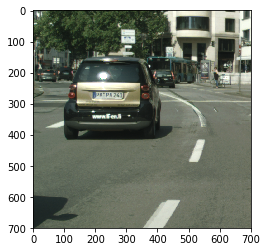

(1, 1024, 88, 88)


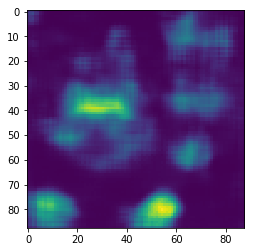

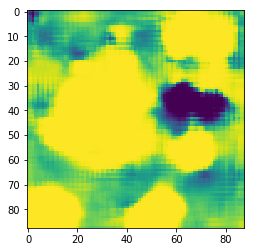

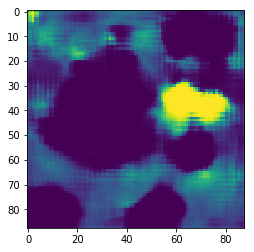

In [14]:
img_fn, label_fn = val_imgs_labels[0]

img = np.asarray(Image.open(img_fn), dtype=np.float32)

plt.imshow(img[200:900, 200:900, :] / 255.)
plt.show()

img = img.transpose(2, 0, 1)
img = road_model.xp.asarray(img)[:, 200:900, 200:900]

pred, maps = road_model.predict(img)

# Concat layer6 and 7
feature_map = cp.concatenate([maps[6].array, maps[7].array], axis=1)
feature_map = cuda.to_cpu(feature_map)
print(feature_map.shape)

plt.imshow(feature_map[0].mean(axis=0))
plt.show()

pred = cuda.to_cpu(F.softmax(pred).array[0])
plt.clf()
plt.imshow(pred[0])
plt.show()
plt.imshow(pred[1])
plt.show()